## Домашнее задание 3
Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

#### Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. Внимание! выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

#### Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод fit / train;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ЛБ - лидерборд, выборка assignment_2_test.csv.

In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

import os
from copy import deepcopy
from inspect import signature
from typing import List, Optional, Union
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.cat_boost import CatBoostEncoder

In [2]:
data = pd.read_csv('./assignment_2_train.csv')
lb_data = pd.read_csv('./assignment_2_test.csv')

In [3]:
data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
target_name = 'isFraud'

In [5]:
data.shape, lb_data.shape

((180000, 394), (100001, 394))

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [7]:
target = data[target_name]

### Задание 1: 
сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [8]:
x_train, x_valid = train_test_split(
    data.drop(["TransactionID", target_name], axis=1), train_size=0.8, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data[target_name], train_size=0.8, shuffle=True, random_state=1,
)

numerical_features = x_train.select_dtypes(exclude=["object"]).columns.tolist()
categorical_features = x_train.select_dtypes(include=["object"]).columns.tolist()
data[categorical_features] = data[categorical_features].astype(str)
lb_data[categorical_features] = lb_data[categorical_features].astype(str)
x_train[categorical_features] = data[categorical_features].astype(str)
x_valid[categorical_features] = data[categorical_features].astype(str)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 392 cols
x_valid.shape = 36000 rows, 392 cols


In [9]:
x_LB = lb_data.drop(["TransactionID", target_name], axis=1)
y_LB = lb_data[target_name]

In [10]:
models = {}
train_scores = dict() 
valid_scores = dict()
LB_scores = dict()

In [11]:
for feature in categorical_features:
    print(f'{feature}:\n{x_train[feature].value_counts()}\n')

ProductCD:
W    88239
H    17948
R    17626
C    17306
S     2881
Name: ProductCD, dtype: int64

card4:
visa                94661
mastercard          43532
american express     3880
discover             1920
nan                     7
Name: card4, dtype: int64

card6:
debit              98117
credit             45861
debit or credit        9
charge card            7
nan                    6
Name: card6, dtype: int64

P_emaildomain:
gmail.com           53894
yahoo.com           23318
nan                 22595
hotmail.com         11971
anonymous.com       10644
aol.com              6857
comcast.net          2362
icloud.com           1325
outlook.com          1169
msn.com              1137
att.net               996
sbcglobal.net         883
verizon.net           784
live.com              718
bellsouth.net         550
ymail.com             523
me.com                497
cox.net               458
yahoo.com.mx          402
optonline.net         299
charter.net           295
live.com.mx        

In [12]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Обработка категориальных признаков и подготовка матрицы
    признаков для передачи в любой алгоритм машинного обучения.

    Parameters
    ----------
    encoder: callable
        Объект для обработки категориальных признаков;
        объект должен поддерживать sklearn-API.

    categorical_features: List[str]
        Список с названием категориальных признаков.

    na_value: float or str, optional, default = None
        Значение для заполнения пропусков.
        Опциональный параметр, по умолчанию, не используется.

    """
    def __init__(self,
                 encoder: callable,
                 categorical_features: List[str],
                 na_value: Union[int, float, str] = None) -> None:
        self.encoder = encoder
        self.categorical_features = categorical_features
        self.na_value = na_value

        sig = signature(encoder.fit)
        self.nparams = len(sig.parameters)
        self.encoders = None

    def _prepare_data(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Подготовка данных для передачи в модель.

        """
        if self.na_value:
            return X[self.categorical_features].fillna(self.na_value)

        return X

    def _check_unique_values(self, y: pd.Series) -> pd.Series:
        """
        Проверка на ранее не встречающиеся значения признака.
        Если значения встречаются - заменяем на self.na_value,
        если self.na_value - не задан, то заменяем на моду.

        """
        encoder = self.encoders[y.name]
        missed_values = list(
            set(y.unique()) - set(encoder.classes_)
        )

        if missed_values:
            mask = y.isin(missed_values)
            if self.na_value:
                y[mask] = self.na_value
            else:
                mode = y.value_counts()[0].index
                y[mask] = mode

        return y

    def _fit_label_encoder(self, X: pd.DataFrame) -> None:
        """
        Обучение LabelEncoder'ов для всех признаков;

        """
        self.encoders = {}
        for feature in self.categorical_features:
            x = X[feature].astype(str)
            encoder = deepcopy(self.encoder)
            self.encoders[feature] = encoder.fit(x)

        return self

    def _transform_label_encoder(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Применение LabelEncoder'ов для всех признаков;

        """
        for feature in self.categorical_features:
            x = X[feature].astype(str)
            x = self._check_unique_values(x)
            encoder = self.encoders.get(feature)
            X[feature] = encoder.transform(x)

        return X

    def fit(self, X, y=None):
        """
        Обучение encoder'а категориальных признаков.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица признаков.

        y: pandas.core.frame.Series
            Вектор целевой переменной.
            Опциональный параметр, по умолчанию, не требуется.

        Returns
        -------
        self
        """
        X = self._prepare_data(X)
        if self.nparams == 1:
            self._fit_label_encoder(X=X)
        else:
            self.encoder.fit(
                X[self.categorical_features].astype(str), y
            )
        return self

    def transform(self, X, y=None):
        """
        Преобразование категориальных признаков.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            Матрица признаков.

        Returns
        -------
        X_transformed: pandas.core.frame.DataFrame
            Преобразованная матрица признаков с
            обработанными категориальными признаками.

        """
        X = self._prepare_data(X)
        if self.encoders:
            categorical = self._transform_label_encoder(X)
        else:
            categorical = self.encoder.transform(
                X[self.categorical_features].astype(str)
            )

        X = X.drop(self.categorical_features, axis=1)
        X = pd.concat([X, categorical], axis=1)

        return X

In [13]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "reg_lambda": 10,
    "max_depth": 4,
    "gamma": 10,
#     "nthread": 6,
    "seed": 27,
    'predictor': 'gpu_predictor',
    'tree_method': 'gpu_hist'
}
eval_sets = [
    (x_train[numerical_features], y_train),
    (x_valid[numerical_features], y_valid)
]
xgb_model = xgb.XGBClassifier(**xgb_params)

In [14]:
encoder = CategoricalEncoder(
    encoder=CatBoostEncoder(random_state=27),
    categorical_features=categorical_features,
)

x_train_catboost_encoder = encoder.fit_transform(x_train, y_train)
x_valid_catboost_encoder = encoder.transform(x_valid)
x_LB_catboost_encoder = encoder.transform(x_LB)

In [15]:
eval_sets = [
    (x_train_catboost_encoder, y_train),
    (x_valid_catboost_encoder, y_valid)
]

xgb_model.fit(
    y=y_train,
    X=x_train_catboost_encoder,
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)
models["Hold_Out_2_samples"] = xgb_model

[0]	validation_0-auc:0.63480	validation_1-auc:0.63095
[10]	validation_0-auc:0.79506	validation_1-auc:0.79917
[20]	validation_0-auc:0.84301	validation_1-auc:0.83794
[30]	validation_0-auc:0.87867	validation_1-auc:0.87073
[40]	validation_0-auc:0.88939	validation_1-auc:0.88006
[50]	validation_0-auc:0.89902	validation_1-auc:0.88802
[60]	validation_0-auc:0.90598	validation_1-auc:0.89331
[70]	validation_0-auc:0.91081	validation_1-auc:0.89810
[80]	validation_0-auc:0.91436	validation_1-auc:0.90055
[90]	validation_0-auc:0.91654	validation_1-auc:0.90272
[100]	validation_0-auc:0.91880	validation_1-auc:0.90440
[110]	validation_0-auc:0.92114	validation_1-auc:0.90602
[120]	validation_0-auc:0.92225	validation_1-auc:0.90683
[130]	validation_0-auc:0.92225	validation_1-auc:0.90683
[140]	validation_0-auc:0.92225	validation_1-auc:0.90683
[150]	validation_0-auc:0.92225	validation_1-auc:0.90683
[160]	validation_0-auc:0.92225	validation_1-auc:0.90683
[165]	validation_0-auc:0.92225	validation_1-auc:0.90683


In [16]:
train_scores["Hold_Out_2_samples"] = xgb_model.predict_proba(
    x_train_catboost_encoder)[:,1]
valid_scores["Hold_Out_2_samples"] = xgb_model.predict_proba(
    x_valid_catboost_encoder)[:,1]
LB_scores["Hold_Out_2_samples"] = xgb_model.predict_proba(
    x_LB_catboost_encoder)[:,1]

In [17]:
print(roc_auc_score(y_train, train_scores["Hold_Out_2_samples"]),
roc_auc_score(y_valid, valid_scores["Hold_Out_2_samples"]),
roc_auc_score(y_LB, LB_scores["Hold_Out_2_samples"]))

0.9222458779220862 0.9068308037904418 0.8616211265204365


Качество на ЛБ заметно ниже, чем на валидной выборке. Данные, которые не видела модель, дествительно полезны для оценки

### Задание 2: 
сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [18]:
x_train, x_valid = train_test_split(
    data.drop(["TransactionID", target_name], axis=1), train_size=0.8, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    data[target_name], train_size=0.8, shuffle=True, random_state=1,
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.8, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.8, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 144000 rows, 392 cols
x_valid.shape = 28800 rows, 392 cols
x_test.shape = 7200 rows, 392 cols


In [19]:
test_scores = dict()

In [20]:
encoder = CategoricalEncoder(
    encoder=CatBoostEncoder(random_state=27),
    categorical_features=categorical_features,
)

x_train_catboost_encoder = encoder.fit_transform(x_train, y_train)
x_valid_catboost_encoder = encoder.transform(x_valid)
x_test_catboost_encoder = encoder.transform(x_test)
x_LB_catboost_encoder = encoder.transform(x_LB)

In [21]:
eval_sets = [
    (x_train_catboost_encoder, y_train),
    (x_valid_catboost_encoder, y_valid)
]

xgb_model.fit(
    y=y_train,
    X=x_train_catboost_encoder,
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)
models["Hold_Out_3_samples"] = xgb_model

[0]	validation_0-auc:0.63480	validation_1-auc:0.63569
[10]	validation_0-auc:0.79506	validation_1-auc:0.80038
[20]	validation_0-auc:0.84301	validation_1-auc:0.83709
[30]	validation_0-auc:0.87867	validation_1-auc:0.87189
[40]	validation_0-auc:0.88939	validation_1-auc:0.88068
[50]	validation_0-auc:0.89902	validation_1-auc:0.88891
[60]	validation_0-auc:0.90598	validation_1-auc:0.89399
[70]	validation_0-auc:0.91081	validation_1-auc:0.89897
[80]	validation_0-auc:0.91436	validation_1-auc:0.90106
[90]	validation_0-auc:0.91654	validation_1-auc:0.90311
[100]	validation_0-auc:0.91880	validation_1-auc:0.90461
[110]	validation_0-auc:0.92114	validation_1-auc:0.90616
[120]	validation_0-auc:0.92225	validation_1-auc:0.90682
[130]	validation_0-auc:0.92225	validation_1-auc:0.90682
[140]	validation_0-auc:0.92225	validation_1-auc:0.90682
[150]	validation_0-auc:0.92225	validation_1-auc:0.90682
[160]	validation_0-auc:0.92225	validation_1-auc:0.90682
[165]	validation_0-auc:0.92225	validation_1-auc:0.90682


In [22]:
train_scores["Hold_Out_3_samples"] = xgb_model.predict_proba(
    x_train_catboost_encoder)[:,1]
valid_scores["Hold_Out_3_samples"] = xgb_model.predict_proba(
    x_valid_catboost_encoder)[:,1]
test_scores["Hold_Out_3_samples"] = xgb_model.predict_proba(
    x_test_catboost_encoder)[:,1]

In [23]:
print(roc_auc_score(y_train, train_scores["Hold_Out_3_samples"]),
roc_auc_score(y_valid, valid_scores["Hold_Out_3_samples"]),
roc_auc_score(y_test, test_scores["Hold_Out_3_samples"]))

0.9222458779220862 0.9068231217922476 0.9067992817169057


### Задание 3: 
построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [24]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true, n_samples=n_samlpes)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [25]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, 
                                  xgb_model.predict_proba(x_test_catboost_encoder)[:,1], 
                                  roc_auc_score)

interval = calculate_confidence_interval(scores)
print(f'roc_auc_score: {roc_auc_score(y_test, test_scores["Hold_Out_3_samples"]):.3f}\
      [{interval[0]:.3f} : {interval[1]:.3f}]')

roc_auc_score: 0.907      [0.880 : 0.931]


In [26]:
LB_scores["Hold_Out_3_samples"] = xgb_model.predict_proba(
    x_LB_catboost_encoder)[:,1]

In [27]:
roc_auc_score(y_LB, LB_scores["Hold_Out_3_samples"])

0.8616211265204365

Видим, что оценка на ЛБ не попадает в доверительный интервал, значит модель переобучена или тестовые данные имеют иное распределение

### Задание 4: 
выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [28]:
x_adv = pd.concat([
    x_train_catboost_encoder, x_LB_catboost_encoder], axis=0
)
y_adv = np.hstack((np.zeros(x_train_catboost_encoder.shape[0]), np.ones(x_LB_catboost_encoder.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [29]:
adv_model = xgb.XGBClassifier(n_estimators=25)
adv_model.fit(x_adv, y_adv)

[18:51:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
y_pred_adv = adv_model.predict_proba(x_adv)
adv_score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(f'{adv_score:.2f}')

1.00


In [31]:
y_pred = adv_model.predict_proba(x_train_catboost_encoder)
y_pred

array([[9.9974763e-01, 2.5233824e-04],
       [9.9974763e-01, 2.5233824e-04],
       [9.9974763e-01, 2.5233824e-04],
       ...,
       [9.9974763e-01, 2.5233824e-04],
       [9.9974763e-01, 2.5233824e-04],
       [9.9974763e-01, 2.5233824e-04]], dtype=float32)

In [32]:
y_pred_cut = pd.cut(y_pred[:, 1], bins=np.arange(0, 1.01, 0.1))
y_pred_cut.value_counts().sort_index()

(0.0, 0.1]    144000
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

In [33]:
x_adv.shape

(244001, 392)

Так я и не понял, что с этим делать

Проверим почему так хорошо тестовая выборка отличается от тренировочной:

<AxesSubplot:>

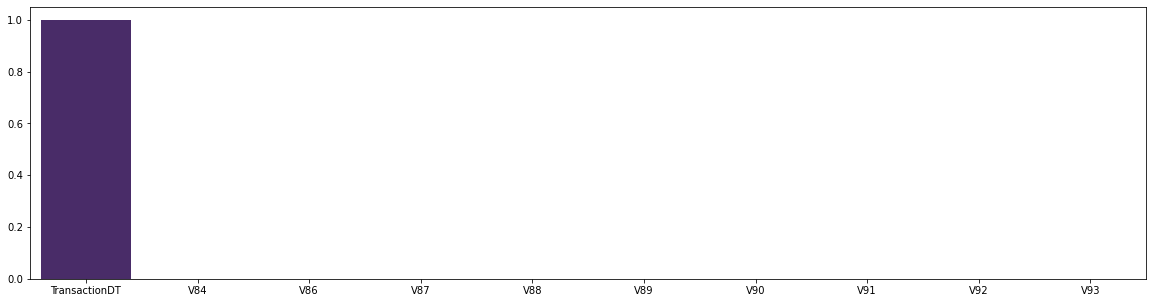

In [34]:
ntop = 10
importances = adv_model.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = x_train_catboost_encoder.columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")

Наверное, можно было бы попробовать обучаться без 'TransactionDT'

In [35]:
x_train_dropDT = x_train_catboost_encoder.drop('TransactionDT', axis=1)
x_valid_dropDT = x_valid_catboost_encoder.drop('TransactionDT', axis=1)
x_test_dropDT = x_test_catboost_encoder.drop('TransactionDT', axis=1)
x_LB_dropDT = x_LB_catboost_encoder.drop('TransactionDT', axis=1)

In [36]:
eval_sets = [
    (x_train_dropDT, y_train),
    (x_valid_dropDT, y_valid)
]

xgb_model.fit(
    y=y_train,
    X=x_train_dropDT,
    early_stopping_rounds=50,
    eval_set=eval_sets,
    eval_metric="auc",
    verbose=10
)
models["Hold_Out_3_samples_dropDT"] = xgb_model

[0]	validation_0-auc:0.63480	validation_1-auc:0.63569
[10]	validation_0-auc:0.80210	validation_1-auc:0.80509
[20]	validation_0-auc:0.84323	validation_1-auc:0.83732
[30]	validation_0-auc:0.87441	validation_1-auc:0.86953
[40]	validation_0-auc:0.88579	validation_1-auc:0.88003
[50]	validation_0-auc:0.89571	validation_1-auc:0.88779
[60]	validation_0-auc:0.90232	validation_1-auc:0.89303
[70]	validation_0-auc:0.90684	validation_1-auc:0.89728
[80]	validation_0-auc:0.91012	validation_1-auc:0.89998
[90]	validation_0-auc:0.91216	validation_1-auc:0.90144
[100]	validation_0-auc:0.91391	validation_1-auc:0.90242
[110]	validation_0-auc:0.91553	validation_1-auc:0.90401
[120]	validation_0-auc:0.91585	validation_1-auc:0.90423
[130]	validation_0-auc:0.91585	validation_1-auc:0.90423
[140]	validation_0-auc:0.91585	validation_1-auc:0.90423
[150]	validation_0-auc:0.91585	validation_1-auc:0.90423
[160]	validation_0-auc:0.91585	validation_1-auc:0.90423
[161]	validation_0-auc:0.91585	validation_1-auc:0.90423


In [37]:
train_scores["Hold_Out_3_samples_dropDT"] = xgb_model.predict_proba(
    x_train_dropDT)[:,1]
valid_scores["Hold_Out_3_samples_dropDT"] = xgb_model.predict_proba(
    x_valid_dropDT)[:,1]
test_scores["Hold_Out_3_samples_dropDT"] = xgb_model.predict_proba(
    x_test_dropDT)[:,1]

In [38]:
print(roc_auc_score(y_train, train_scores["Hold_Out_3_samples_dropDT"]),
roc_auc_score(y_valid, valid_scores["Hold_Out_3_samples_dropDT"]),
roc_auc_score(y_test, test_scores["Hold_Out_3_samples_dropDT"]))

0.9158551136918239 0.9042308202235546 0.8984807963876636


In [39]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, 
                                  xgb_model.predict_proba(x_test_dropDT)[:,1], 
                                  roc_auc_score)

interval = calculate_confidence_interval(scores)
print(f'roc_auc_score: {roc_auc_score(y_test, test_scores["Hold_Out_3_samples_dropDT"]):.3f}\
      [{interval[0]:.3f} : {interval[1]:.3f}]')

roc_auc_score: 0.898      [0.870 : 0.923]


In [40]:
LB_scores["Hold_Out_3_samples_dropDT"] = xgb_model.predict_proba(
    x_LB_dropDT)[:,1]

In [41]:
roc_auc_score(y_LB, LB_scores["Hold_Out_3_samples_dropDT"])

0.8650422163719043

Качество улучшилось, но до доверительного интервала не дотягивает

Еще раз попробуем, но без DT:

In [42]:
x_adv_dropDT = x_adv.drop('TransactionDT', axis=1)

In [43]:
y_pred_adv = adv_model.predict_proba(x_adv_dropDT)
adv_score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(f'{adv_score:.2f}')

0.50


Теперь данные похожи, но почему тогда оценка не попала в доверительный интервал?

### Задание 5: 
сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [44]:
cv = cross_val_score(
    estimator=models['Hold_Out_3_samples'],
    X=x_test_catboost_encoder,
    y=y_test,
    scoring='roc_auc',
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-results: 0.8511 +/- 0.033


In [45]:
cv = cross_val_score(
    estimator=models['Hold_Out_3_samples'],
    X=x_LB_catboost_encoder,
    y=y_LB,
    scoring='roc_auc',
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-results: 0.8692 +/- 0.012


Кросс-валидация на трейне сумела вместить в свой доверительный интервал валидацию на ЛБ. Видимо, метрика качества 0.9 была всё-таки выбросом

### Задание 6 (опциональное): 
сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.
​
Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

### Задание 7 (совсем опциональное): 
в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).